# Demo Convolutional Neural Network (CNN o ConvNet) para clasificar (atributo clase discreto) o estimar (atributo clase continuo)

In [ ]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

import os
import csv

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [ ]:
# @title Acceder al Drive {"single-column":true}

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = '/content/gdrive/MyDrive/demosColab/demoIA/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [ ]:
#@title Cargar datos

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}
separador_decimal = '.' #@param {type:"string"}

# funciones auxiliares

# importa datos
def cargarDatosDF(path, archivo_datos, delimitador_columnas, separador_decimal, mostrarEstadisticas=True):
  if os.path.isfile( path + '/' + archivo_datos ):
    # existe el archivo
    if ((delimitador_columnas is None) or (delimitador_columnas=="")):
      # si no se define asume ","
      delimitador_columnas = ","
    if ((separador_decimal is None) or (separador_decimal=="")):
      # si no se define asume "."
      separador_decimal = "."
    if (delimitador_columnas==separador_decimal):
      # ambos delimitadores iguales, cambia el decimal
      if delimitador_columnas == ",":
        separador_decimal = "."
      else:
        separador_decimal = ","
      print("- Ambos delimitadores configurados igual, se cambia separador decimal a '" + separador_decimal + "'!")
    # carga datos
    df = pd.read_csv(path + archivo_datos,
                     sep=delimitador_columnas, decimal=separador_decimal,
                     skip_blank_lines=True,
                     engine="python")
    print("> Archivo de datos", archivo_datos, "cargado")
    # muestra estadísticas
    if mostrarEstadisticas:
      print("\n> Cabecera: ")
      print(df.head())
      print("\n> Características: ")
      print(df.describe())
      print("\n")
    # controla que el archivo tenga sentido
    if len(df.columns.values.tolist())<2:
      print("\n> El archivo de datos debería tener al menos 2 columnas, revise delimitador de columnas!")
      return None
    else:
      return df
  else:
    print("No existe archivo de datos ", archivo_datos, "!")
    return None

# importa definición axiliar de las clases (si existe)
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    # si existe, carga los datos
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    # no encontrado
    return "", ""

# inicializa valores
X = None
Y = None

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## aplicación de los parámetros elegidos

# Carga los datos del CSV y muestra los primeros
df = cargarDatosDF(path, archivo_datos,
                   delimitador_columnas, separador_decimal, mostrarEstadisticas=True)

if df is not None:

  # intenta cargar configuración asociada a los datos
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

  # muestra interface para cargar configuración de los parámetros

  # función auxiliara para que no ejecute UI cada vez
  def hacerNada():
      return

  # se define esta función para que se ocupe de aplicar la configuración
  def on_buttonAplicar_clicked(b):
      print("")
      funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

  # aplica configuración de datos
  def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
      global Y, X, nombre_clases

      if (attClase is None) or (attClase =="") or\
        (att_entrada is None) or (att_entrada ==""):
        return

      # si el atributo clase está como de entrada, lo saca (no tiene sentido)
      att_entrada = list(att_entrada)
      if (attClase in att_entrada):
        print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
        att_entrada.remove( attClase )

      if (att_entrada == "") or (len(att_entrada)==0):
        print("No se han definido atributos de entrada!")
        return

      # guarda configuración
      nombre_clases = nomClases

      # genera los datos solo con los atributos seleccionados
      # para clase
      if (attClase in df):
        Y = np.array(df[attClase])
      else:
        print("Atributo " + attClase + " no encontrado !")
        X = None
        Y = None
        return
      # para entrada
      X = np.array(df[att_entrada])

      # muestra resultados
      print("\n> Atributos entrada: ", att_entrada)
      print("\t X: ", X.shape)

      if (nombre_clases is None) or (nombre_clases==""):
        print("\n> Atributo clase: ", attClase)
      else:
        print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
      print("\t Y: ", Y.shape)

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}

  tit = widgets.Label("Ajuste para configuración de los Datos: ")

  # prepara combo para determinar atributo clase
  selecc_atributos = [ ]
  selecc_atributos.extend( df.columns.values.tolist() )
  if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
    att_selecc_defecto = len(selecc_atributos)-1
  else:
    att_selecc_defecto = selecc_atributos.index(atributo_clase)
  combo_att_clase = widgets.Dropdown(
      options = selecc_atributos,
      value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
      description = 'Atributo clase:',
      style=style_3D,
      disabled = False,
  )
  # prepara campo para ingresar nombre clases (toma por defecto de config)
  texto_nomClases = widgets.Text(
      value=nombre_clases,
      placeholder='Ingrese nombre clases (si corresponde) separados por comas',
      description='Nombre clases:',
      style=style_3D,
      disabled=False
  )

  combo_att_entrada = widgets.SelectMultiple(
      options=selecc_atributos,
      value=selecc_atributos,
      #rows=10,
      description='Atributos de entrada:',
      style=style_3D,
      disabled=False
  )

  # prepara botón y grilla con objetos
  btnAplicar = widgets.Button(
      description='Aplicar'
  )
  configDatos_ui = widgets.GridBox(
        children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
        layout=Layout(width='100%')  )
  btnAplicar.on_click(on_buttonAplicar_clicked)

  #clear_output()
  out_config = widgets.interactive_output(hacerNada, {})
  display(configDatos_ui)

  # ejecuta para que muestre
  on_buttonAplicar_clicked(btnAplicar)


> Archivo de datos IRIS.csv cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [ ]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

In [ ]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "discreto - CLASIFICACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100.0

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# inicializa listas
x_train, x_test, y_train, y_test = [], [], [], []
y_trainEnc, y_testEnc = [], []

# control aque haya datos definidos
assert (X is not None), "No se cargaron datos de atributos de entrada!"
assert (len(X)>0), "No se cargaron datos de atributos de entrada!"
assert (Y is not None), "No se cargaron datos de atributo clase!"
assert (len(Y)>0), "No se cargaron datos de atributo clase!"

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("** No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  ## CLASIFICAR
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
    # toma los valores de clase orginales del archivo
    if str(Y[0]).replace(".","").isnumeric():
      # Y son números
      print("-- Utiliza valores numéricos como clase.")
      for val in range(int(np.max(Y))+1):
        CLASES.append( "clase {:>3}".format(val) )
    else:
        # Y no son números
        print("-- Utiliza valores alfanuméricos como clase.")
        CLASES = list(set(Y))
        CLASES.sort()
        # cambia valores para que sean enteros
        y_train = [ CLASES.index(y) for y in y_train]
        y_test = [ CLASES.index(y) for y in y_test]
  else:
    # toma configuración de nombre de clases
    print("-- Utiliza nombres de clase definidos.")
    for val in nombre_clases.split(','):
      CLASES.append( val )

  # controla, con advertencias
  if len(CLASES) == 0:
    print("** No se encontraron clases!\n")
  elif len(CLASES) > 10:
    print("** Se detectaron más de 10 clases, revise los datos y el tipo de problema seleccionado!\n")
  # genera salida codificada para softMax
  y_trainEnc = to_categorical(y_train)
  y_testEnc = to_categorical(y_test)
  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES )
else:
  ## ESTIMAR
  print("> se considera problema de ESTIMACIÓN \n")
  if not(str(Y[0]).replace(".","").isnumeric()):
    print("-- Detecta valores alfanuméricos en atributo clase -> convierte a númerico:")
    CLASES = list(set(Y))
    CLASES.sort()
    # cambia valores para que sean enteros
    y_train = [ CLASES.index(y) for y in y_train]
    y_test = [ CLASES.index(y) for y in y_test]
    print(" - dictMapeo (", len(CLASES), "): ", [ str(i) + " : " +CLASES[i]  for i in range(len(CLASES)) ] )

# convierte a numpy para usar por modelo
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# muestra ejemplos
print("\n> Datos para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    print("    ", CLASES[i], "[", i, "]:", np.sum(y_train == i))

print("\n Datos para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    print("    ", CLASES[i], "[", i, "]:", np.sum(y_test == i))
print("")


> se considera problema de CLASIFICACIÓN 

-- Utiliza nombres de clase definidos.
> Definición de CLASES: 
 - dictMapeo ( 4 ):  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Datos para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112
     na [ 0 ]: 0
     Setosa [ 1 ]: 38
     Versicolor [ 2 ]: 37
     Virginica [ 3 ]: 37

 Datos para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38
     na [ 0 ]: 0
     Setosa [ 1 ]: 12
     Versicolor [ 2 ]: 13
     Virginica [ 3 ]: 13



# Modelo:

In [ ]:
#@title Establecer modelo


#@markdown ### Parámetros de las capas ConvNet:
convNet_cantidad_capas =  1#@param {type:"integer"}
convNet_tipo_funcion = 'relu' #@param ['exponential', 'linear', 'relu', 'sigmoid', 'tanh' ]
convNet_kernel_tamaño_N =  2 #@param {type:"integer"}
convNet_pooling_tamaño_M = 2 #@param {type:"integer"}
convNet_pooling_tipo = 'Max-Pooling' #@param ["Max-Pooling", "Avg_Pooling"]
convNet_reshape_lineal = 'Flatten' #param ["Flatten", "GlobalAveragePooling"]

#@markdown ### Parámetros de las capas Lineales:
lineal_cant_neuronas_capas_ocultas = '8' #@param {type:"string"}
lineal_tipo_funcion = 'relu' #@param ['exponential', 'linear', 'relu', 'sigmoid', 'tanh' ]
#markdown (Nota: se puede indicar Cantidad de neuronas, D para DropOut, BN para BatchNormalization)
lineal_porc_capa_DropOut = 0.3 #param {type:"number"}
rna_tipo_capa_salida = 'softmax-MultiClase' #@param ["identidad-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "RMSprop", "Momentum", "NAG", "Nadam"]
opt_learning_rate = 0.01 #@param {type: "number"}

## controla los parámetros elegidos

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
if esProblemaClasificacion:
  tipo_output_softMax = (rna_tipo_capa_salida[:7] == 'softmax')
else:
  print("-- se considera salida lineal porque es problema de Estimación!")
  tipo_output_softMax = False


### funciones auxiliares para crear modelo ###

# agrega capa entrada
def agregarCapaEntrada(num_inputs):
  return tf.keras.layers.Input(shape=(num_inputs,), name='input')

# agrega capas Conv2D + MaxPooling
def agregarCapasConvolucionalesDatos(eachLay, cant_capas, tipo_funcion="relu", kernel_shape_N=1, pooling_shape_M=1, pooling_type="M", reshape_type="F"):
  # controla cantidad de capas cnn
  if cant_capas<1:
    # si cantidad menor que 1 no agrega
    print("No se agregan capas convolucionales!")
    return eachLay
  # valida capa anterior
  assert eachLay is not None, "Capa anterior no definida!"
  # valida kernel y pool shape
  cnn_kernel_shape = ( max(kernel_shape_N, 1) )
  cnn_pooling_shape = ( max(pooling_shape_M, 1) )
  # determina pool type
  if pooling_type == 'A':
    cnn_pooling_type = tf.keras.layers.AveragePooling1D
  else:
    cnn_pooling_type = tf.keras.layers.MaxPooling1D
  #  agrega capa Reshape para poder procesar datos lineales  por capas convolucionales
  if len(eachLay.shape)>0:
    num_inputs = eachLay.shape[1]
    matrixShape = None
    for val in [2, 3, 5, 7, 11]:
      if (num_inputs%val)==0:
        matrixShape = [val,(num_inputs//val)]
        break
    if matrixShape is None:
      matrixShape = [1, num_inputs]
    eachLay = tf.keras.layers.Reshape(matrixShape, name="reshape_input" )(eachLay)
  # agrega capas convolucionales
  auxId = 0
  for i in range(cant_capas, 0, -1):
      # define automática cantidad de filtros
      # para que decrementen por capa según recomendación
      cnn_filters =  2**(i+2)
      # define el nombre de la capa oculta
      auxId += 1
      auxlayerName = 'conv_'+str(auxId)
      # agrega las capas ocultas de tipo Conv2D + MaxPooling
      eachLay =  tf.keras.layers.Conv1D(cnn_filters,
                                        cnn_kernel_shape,
                                        activation=tipo_funcion,
                                        padding='same',
                                        name=auxlayerName+'_cf')(eachLay)
      # determina nombre y shape de la capa conv2D
      last_conv_layer_name = 'c_'+auxlayerName
      last_conv_layer_shape = (eachLay.shape[1], eachLay.shape[2])
      ##print(last_conv_layer_name, last_conv_layer_shape, eachLay.shape)
      eachLay =  cnn_pooling_type(cnn_pooling_shape,
                                 padding='same',
                                 name=auxlayerName+'_p')(eachLay)
  # agrega capa reshape a vector
  if reshape_type == "G":
    #  agrega capa GlobalAveragePooling2D
    eachLay = tf.keras.layers.GlobalAveragePooling1D(name='flat_GAP')(eachLay)
  else:
    #  agrega capa Flatten
    eachLay = tf.keras.layers.Flatten(name='flat')(eachLay)
  # devuelve última
  return eachLay


# agrega capas lineales (Dense, DO, BN) según configuración
def agregarCapasLineales(eachLay, configCapasList, tipo_funcion="relu", porc_capa_DropOut=0.1):
  # valida capa anterior
  assert eachLay is not None, "Capa anterior no definida!"
  # chequea configuración de drop out
  lineal_porc_capa_DropOut = min(max(0.1, porc_capa_DropOut), 0.9)
  # recorre lista de configuración
  auxId = 1
  for val_hid in configCapasList:
    # saca espacios por las dudas
    val_hid = val_hid.strip()
    # evalúa
    if val_hid.upper() == "D":
      # agrega Drop-Out
      auxlayerName = "d_"+str(auxId)
      auxId = auxId + 1
      eachLay = tf.keras.layers.Dropout(porc_capa_DropOut,
                                        name=auxlayerName)(eachLay)
    elif val_hid.upper() == "BN":
      # agrega BatchNormalization
      auxlayerName = "bn_"+str(auxId)
      auxId = auxId + 1
      eachLay = tf.keras.layers.BatchNormalization(name=auxlayerName)(eachLay)
    elif val_hid.isnumeric():
      # agrega Dense (MLP)
      auxlayerName = 'hidd_'+str(auxId)
      auxId = auxId + 1
      eachLay = tf.keras.layers.Dense(int(val_hid), activation=tipo_funcion,
                                      name=auxlayerName)(eachLay)
    else:
      # otras
      print("Tipo capa configurada", val, "descartada!")
  #devuelve última capa
  return eachLay


# agrega capa salida con configuración del modelo (loss y metrics para modelo)
def agregarCapaSalida(eachLay, esProblemaClasificacion, usarSoftMax=False, cantClases=1):
  # valida capa anterior
  assert eachLay is not None, "Capa anterior no definida!"
  # determina capa de salida,
  if esProblemaClasificacion:
    # métrica para clasificación
    metricsType= ['accuracy']
    if usarSoftMax:
        # capa de salida softmax
        output_Lay = tf.keras.layers.Dense(units=cantClases, activation='softmax', name='output')(eachLay)
        # utiliza un loss de multiple clases
        lossType = 'categorical_crossentropy'
    else:
        # capa de salida lineal
        output_Lay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay)
        # utiliza un loss de valor numérico
        lossType = 'mse'
  else:
    # capa de salida lineal
    output_Lay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay)
    # métrica para estimación
    metricsType=['RootMeanSquaredError']
    # utiliza un loss de valor numérico
    lossType = 'mse'
  return output_Lay, metricsType, lossType

# define algoritmo de optimización
def definirOpt(opt_tipo, opt_learning_rate=0.01):
  # chequea configuracion LR
  opt_learning_rate = min(max(0.00001, opt_learning_rate), 10)
  # determina algoritmo de optimización
  if opt_tipo == "Gradiente Decreciente":
    opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adam":
    opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adadelta":
    opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adagrad":
    opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adamax":
    opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
  elif opt_tipo == "Nadam":
    opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
  elif opt_tipo == "RMSprop":
    opt = keras.optimizers.RMSprop(learning_rate=opt_learning_rate)
  elif opt_tipo == "Momentum":
    opt = keras.optimizers.SGD(learning_rate=opt_learning_rate, momentum=0.9, nesterov=False)
  elif opt_tipo == "NAG":
    opt = keras.optimizers.SGD(learning_rate=opt_learning_rate, momentum=0.9, nesterov=True)
  else:
    # por defecto usa ADAM
    opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
  return opt


### fin funciones auxiliares para crear modelo ###


## construye la ConvNet
# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente

# capa de entrada en base a tamaño de datos de entrada
input_Lay = agregarCapaEntrada(num_inputs=x_train.shape[1])
eachLay = input_Lay

# capas ocultas convolucionales
eachLay = agregarCapasConvolucionalesDatos(eachLay,
                                      cant_capas=max(convNet_cantidad_capas, 1),
                                      tipo_funcion=convNet_tipo_funcion,
                                      kernel_shape_N=convNet_kernel_tamaño_N,
                                      pooling_shape_M=convNet_pooling_tamaño_M,
                                      pooling_type=convNet_pooling_tipo.upper()[0],
                                      reshape_type=convNet_reshape_lineal.upper()[0])

# capas ocultas lineales
eachLay = agregarCapasLineales(eachLay,
                               configCapasList=lineal_cant_neuronas_capas_ocultas.split(','),
                               tipo_funcion=lineal_tipo_funcion,
                               porc_capa_DropOut=lineal_porc_capa_DropOut)

# capa salida
output_Lay, metricsType, lossType = agregarCapaSalida(eachLay,
                                                      esProblemaClasificacion=esProblemaClasificacion,
                                                      usarSoftMax=tipo_output_softMax,
                                                      cantClases=len(CLASES))

# determina optimizador
optModel = definirOpt(opt_tipo=opt_tipo,
                      opt_learning_rate=opt_learning_rate)

# genera el modelo RNA MLP Backpropagation
model = Model(input_Lay, output_Lay, name='ConvNet')
model.compile(optimizer=optModel, loss=lossType, metrics=metricsType)

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")


Modelo creado con  7  capas:


Model: "ConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_input (Reshape)         │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_cf (Conv1D)              │ (None, 2, 8)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_p (MaxPooling1D)         │ (None, 1, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_GAP                        │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidd_1 (Dense)                  │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148 (592.00 B)

 Trainable params: 148 (592.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:

#@title Visualizar modelo

mostrar_modelo = False #@param {type:"boolean"}
if mostrar_modelo:
  if  (model is None):
    print("Modelo no disponible.")
  else:
    print("Modelo creado con ", len(model.layers), " capas:")
    display(plot_model(model, show_layer_names=True, show_shapes=True))



In [ ]:
#@title Entrenar modelo

cant_epocas_entrenamiento = 150 #@param {type:"integer"}
porcentaje_datos_validacion = 5 #@param {type:"number"}

#@markdown Configración para Early Stopping:
activar_corte_por_estabilidad_val_loss = True #@param {type:"boolean"}
epoca_comienza_monitorear_estabilidad = 20 #@param {type:"integer"}
min_cambio_val_loss_considera_mejora = 0.001 #@param {type:"number"}
epocas_paciencia_estabilidad = 25 #@param {type:"integer"}
devolver_pesos = "Mejores" #@param ["Mejores", "Ultimos"]


## controla parámetros

# controla cantida de épocas
cantEpocas = max(1,cant_epocas_entrenamiento)

# controla porcentaje de validación
porcentaje_datos_validacion = min(49.9, porcentaje_datos_validacion)
porcentaje_datos_validacion = max(0.5, porcentaje_datos_validacion)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento se toma " + str(round((100-porcentaje_datos_validacion), 1)) + "% para entrenar y " + str(round(porcentaje_datos_validacion, 1)) + "% para validar. ")

# controla capa de entrada vs datos de entrada para entrenamiento
assert len(model.input.shape)==len(x_train.shape), "* La forma de la capa de entrada NO es igual a la de los datos de entrada! : " + str(model.input.shape) + " != " + str(x_train.shape)
for i in range(1, len(model.input.shape)):
  assert model.input.shape[i]==x_train.shape[i], "* La forma de la capa de entrada NO es igual a la de los datos de entrada! : " + str(model.input.shape[i]) + " != " + str(x_train.shape[i])

# controla capa de salida vs datos de salida para entrenamiento
if tipo_output_softMax:
  assert len(model.output.shape)>=len(y_trainEnc.shape), "* La forma de la capa de salida softmax NO es igual a la de los datos de salida encoded! : " + str(model.output.shape) + " != " + str(y_trainEnc.shape)
  for i in range(1, len(model.output.shape)):
    assert model.output.shape[i]==y_trainEnc.shape[i], "* La forma de la capa de salida softmax NO es igual a la de los datos de salida encoded! : " + str(model.output.shape[i]) + " != " + str(y_trainEnc.shape[i])
else:
  # nota y_train puede tener una dimensión menos que outpout shape para datos lineales
  assert len(model.output.shape)>=len(y_train.shape), "* La forma de la capa de salida lineal NO es igual a la de los datos de salida! : " + str(model.output.shape) + " != " + str(y_train.shape)
  for i in range(1, len(y_train.shape)):
    assert model.output.shape[i]==y_trainEnc.shape[i], "* La forma de la capa de salida lineal NO es igual a la de los datos de salida! : " + str(model.output.shape[i]) + " != " + str(y_train.shape[i])

# configura ealy stopping
callbacksList = []
if activar_corte_por_estabilidad_val_loss:
  # válida parámetros de early stopping
  min_cambio_val_loss_considera_mejora = max(0, min_cambio_val_loss_considera_mejora)
  epocas_paciencia_estabilidad = max(1, epocas_paciencia_estabilidad)
  epoca_comienza_monitorear_estabilidad = max(2, epoca_comienza_monitorear_estabilidad)

  # se agrega un callBack para que corte
  # si el error de validación no sigue bajando
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=min_cambio_val_loss_considera_mejora,
      patience=epocas_paciencia_estabilidad,
      verbose=1,
      mode='min',
      baseline=None,
      restore_best_weights=(devolver_pesos == "Mejores"),
      start_from_epoch=epoca_comienza_monitorear_estabilidad
  )
  callbacksList = [early_stopping_monitor]
  print("\n> Se activa Early Stopping.")

# determina la época en que se activo early stopping
# (si se uso y terminó antes)
def getEarlyStoppingEppoch(callbacksList):
  if callbacksList is not None:
    for earlyStopCB in callbacksList:
      if isinstance(earlyStopCB, keras.callbacks.EarlyStopping):
        if earlyStopCB.restore_best_weights:
          # si restaura mejor
          if (earlyStopCB.best_epoch>0):
            # se detuvo por early stopping, devuelve la época correspondiente
            return earlyStopCB.best_epoch+1
        else:
         if (earlyStopCB.stopped_epoch>0):
            # se detuvo por early stopping, devuelve la época correspondiente
            return earlyStopCB.stopped_epoch+1
  return None

# registra tiempo proceso comienzo
import time
start_process_time = time.process_time()

print("\n\n> Comienza el Entrenamiento:")

# lleva a cabo el entrenamiento
history = model.fit(x=x_train,
                    y = y_trainEnc if tipo_output_softMax else y_train,
                    epochs = cantEpocas,
                    validation_split=porcentaje_datos_validacion/100.0,
                    callbacks=callbacksList)

# registra tiempo fin y duración
process_duration = time.process_time() - start_process_time

if process_duration>60:
  print(f"\n> Entrenamiento Finalizado: {process_duration/60.0:.3f} minutos.")
else:
  print(f"\n> Entrenamiento Finalizado: {process_duration:.3f} segundos.")

# identifca epoch que terminó early stopping (o None)
epoch_earlyStopping = getEarlyStoppingEppoch(callbacksList)




> De los  112 ejemplos de entrenamiento se toma 95% para entrenar y 5% para validar. 

> Se activa Early Stopping.


> Comienza el Entrenamiento:
Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.0523 - loss: 1.4037 - val_accuracy: 0.3333 - val_loss: 1.1690
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4452 - loss: 1.1986 - val_accuracy: 0.5000 - val_loss: 0.9218
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6589 - loss: 1.0513 - val_accuracy: 0.8333 - val_loss: 0.7360
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8165 - loss: 0.8967 - val_accuracy: 1.0000 - val_loss: 0.5942
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7305 - loss: 0.7808 - val_accuracy: 0.8333 - val_loss: 0.4828
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6932 - loss: 0.6631 - val_accuracy: 1.0000 - val_loss: 0.3558
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8336 - loss: 0.5567 - val_accura

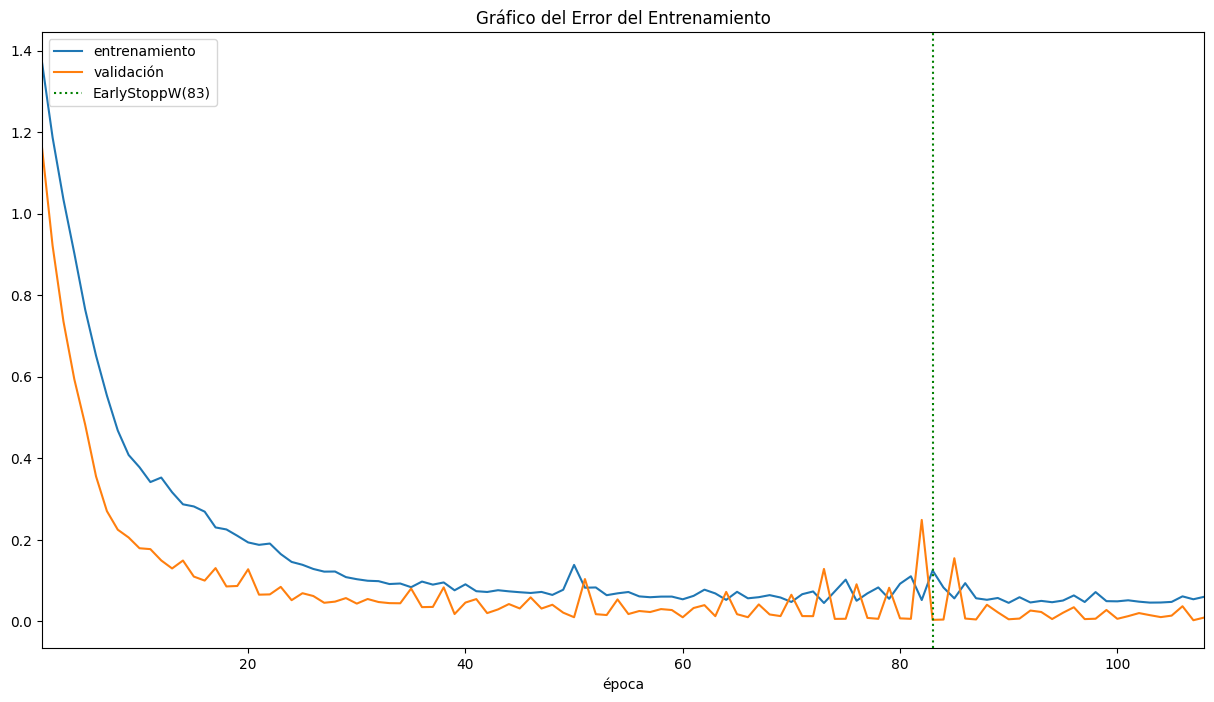

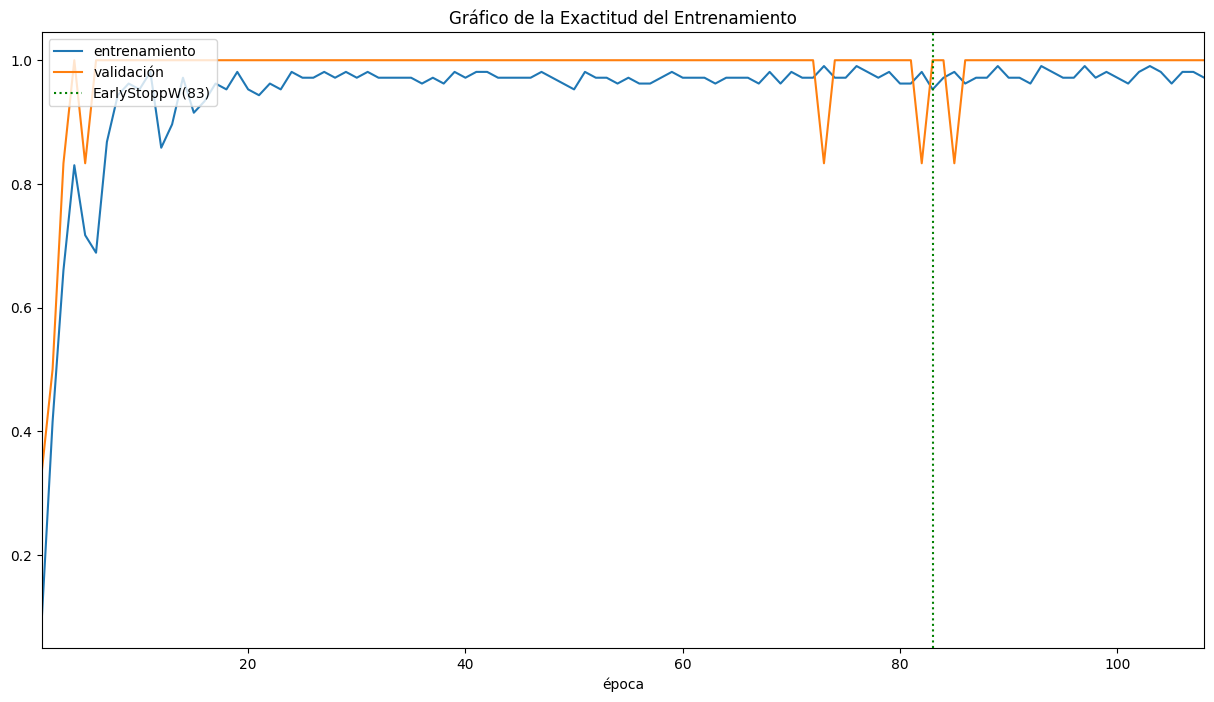

In [ ]:
#@title Mostrar Gráficos del Entrenamiento

# gráfico de LOSS
plt.figure(figsize=(15,8))
plt.plot([None] + history.history['loss']) # agrega valor None para epoch 0
plt.plot([None] + history.history['val_loss']) # agrega valor None para epoch 0
legendsLabels = ['entrenamiento', 'validación']
plt.ylabel('')
plt.xlabel('época')
plt.title('Gráfico del Error del Entrenamiento')
# resalta época de early_stopping_monitor (si se detuvo antes)
if epoch_earlyStopping is not None:
  esLabel = "EarlyStoppW("+str(epoch_earlyStopping)+")"
  plt.axvline(x=epoch_earlyStopping, color='g', linestyle=':', label=esLabel)
  legendsLabels.append( esLabel )

plt.legend(legendsLabels, loc='upper left')
plt.margins(x=0) # para que arranque en eje de coordenadas
plt.show()

# gráfico de MÉTRICAS
plt.figure(figsize=(15,8))
if esProblemaClasificacion:
  plt.plot([None] + history.history['accuracy']) # agrega valor None para epoch 0
  plt.plot([None] + history.history['val_accuracy']) # agrega valor None para epoch 0
  plt.title('Gráfico de la Exactitud del Entrenamiento')
else:
  plt.plot([None] + history.history['RootMeanSquaredError']) # agrega valor None para epoch 0
  plt.plot([None] + history.history['val_RootMeanSquaredError']) # agrega valor None para epoch 0
  plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')
legendsLabels = ['entrenamiento', 'validación']
plt.ylabel('')
plt.xlabel('época')
# resalta época de early_stopping_monitor (si se detuvo antes)
if epoch_earlyStopping is not None:
  plt.axvline(x=epoch_earlyStopping, color='g', linestyle=':')
  legendsLabels.append( esLabel )
plt.legend(legendsLabels, loc='upper left')
plt.margins(x=0)
plt.show()

### Evaluación del Modelo:

*** Resultados con datos de Entrenamiento: 
 Clase Real / Clase Modelo [resultado]
   R: Versicolor [2] / M: Versicolor [1.4420986e-04 7.2472133e-03 9.9126655e-01 1.3420708e-03] -> OK 
   R: Versicolor [2] / M: Versicolor [6.0858179e-05 2.1747354e-04 9.8857605e-01 1.1145620e-02] -> OK 
   R: Virginica [3] / M: Virginica [3.4011750e-06 4.4155946e-08 8.0012134e-04 9.9919647e-01] -> OK 
   R: Versicolor [2] / M: Versicolor [9.9574005e-05 1.3788687e-03 9.9567366e-01 2.8478387e-03] -> OK 
   R: Virginica [3] / M: Virginica [7.6069184e-05 6.1910991e-06 1.3836691e-02 9.8608094e-01] -> OK 
   R: Virginica [3] / M: Virginica [1.1328453e-06 6.6457719e-09 1.0400176e-03 9.9895883e-01] -> OK 
   R: Virginica [3] / M: Virginica [7.8787583e-05 6.1422857e-06 1.7771304e-02 9.8214370e-01] -> OK 
   R: Versicolor [2] / M: Versicolor [8.4305048e-04 3.3627008e-03 9.0643346e-01 8.9360833e-02] -> OK 
   R: Versicolor [2] / M: Versicolor [0.0007207  0.00088687 0.6326658  0.3657267 ] -> OK 
   R: Versicolor [2

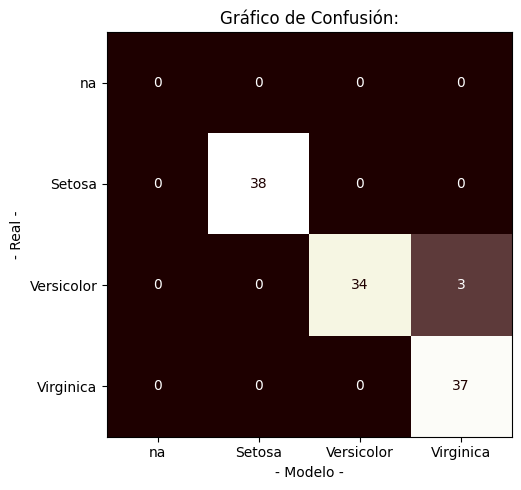

In [ ]:
#@title Evaluar con datos de entrenamiento

umbral_clasificacion = 50 #@param {type:"slider", min:1, max:99, step:1}
#@markdown ('umbral_clasificacion' sólo se usa para clasificación con salida lineal)
mostrar_detalle_entrenamiento = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}

# genera gráfico de los errores para Estimación
def generaResumen_Estimacion(ar, tit, b=10, c=None):
    # muestra resumen
    print("\n Estadísticas para " + tit + ": ")
    print("            Mínimo: {:.4f} ".format(np.min(ar)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(ar), np.std(ar)) )
    print("            Máximo: {:.4f} ".format(np.max(ar)) )
    # muestra gráfico
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()
    return

# función auxiliar para probar el modelo entrenado para Estimación
def analizarModelo_Estimacion(datosX, datosY, predsY, mostrarDetalle=False, inclDatosEntrada=False):
    # muestra títulos
    if mostrarDetalle:
      if inclDatosEntrada:
        print(" Datos ->", end="")
      print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")
    # procesa
    arAbs = []
    arRel = []
    for x, r, pV in zip(datosX, datosY, predsY):
      # toma el valor estimado/predecido
      p = interpretarPredsModelo(pV, esProblemaClasificacion=False)
      # controla que sean números
      if not(math.isnan(r) or math.isnan(p)):
        # hace los cálculos
        eAbs = abs(r - p)
        if r == 0:
          eRel = (eAbs / 1)*100.0
        else:
          eRel = (eAbs / r)*100.0
        # agrega a lista para estadística
        arAbs.append(eAbs)
        arRel.append(eRel)
        # muestra
        if mostrarDetalle:
          if inclDatosEntrada:
            print(" " + str(x) + "->", end="")
          print(" R: {:>10.4f} / M: {:>10.4f} [ {:>10.4f} | {:>10.2f}% ]".format(r, p, eAbs, eRel))
      else:
        # muestra inválidis
        if mostrarDetalle:
          if inclDatosEntrada:
            print(" " + str(x) + "->", end="")
          print(" descarta valores inválidos R: ", r," / M: ", p, "!")
    # muestra estadísticas de métricas
    generaResumen_Estimacion(arAbs, "Error Absoluto", 20, "red")
    generaResumen_Estimacion(arRel, "Error Relativo", 10, "magenta")
    return

def generaResumen_Clasificacion(classReal, classPreds, clases_labels):
    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))
    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_labels)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_labels],
        columns=['m:{:}'.format(x) for x in clases_labels]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")
    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clases_labels)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()
    return

# función auxiliar para probar el modelo entrenado en detalle
def analizarModelo_Clasificacion(datosX, datosY, predsY, clases_map=None, tipo_output_softMax=False, umbralClas=0.5, mostrarDetalle=False, inclDatosEntrada=False):
    # hace copia de classMap por si hay clases inválidas
    if clases_map is None:
      dict_clases_map = {}
    else:
      dict_clases_map = dict(enumerate(clases_map))
    # muestra títulos
    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo [resultado]")
      else:
        print(" Clase Real / Clase Modelo [resultado]")
    # procesa
    classPreds = []
    classReal = []
    for x, rId, pV in zip(datosX, datosY, predsY):
      # determina nombre clase real (agrega si no existe)
      clReal, dict_clases_map = asignarClassName(rId, dict_clases_map)
      # determina el ID de clase predecida
      pId = interpretarPredsModelo(pV, esProblemaClasificacion=True,
                                  tipo_output_softMax=tipo_output_softMax, umbralClas=umbralClas)
      # asigna nombre de clase (agrega si no existe)
      clPred, dict_clases_map = asignarClassName(pId, dict_clases_map)
      # agrega a listas
      classReal.append( clReal )
      classPreds.append( clPred )
      # muestra
      if mostrarDetalle:
        strCompara = "  "
        if inclDatosEntrada:
          strCompara = strCompara + str(x) + '-> '
        strCompara = strCompara +" R: {} [{}] / M: {} {}".format(clReal, rId, clPred, pV)
        strCompara = strCompara + " -> " + ("OK" if (clPred==clReal) else "ERROR!") + " "
        print(strCompara)
    # define lista de valores de clases
    clases_labels = list(dict_clases_map.values())
    # muestra matrices resumen
    generaResumen_Clasificacion(classReal, classPreds, clases_labels)
    return

# función que asigna nombre de clase en base a Id
# (si no existe lo agrega)
def asignarClassName(classId, dict_clases_map):
  if (classId in dict_clases_map):
    # nombre existe
    clName = dict_clases_map[classId]
  else:
    # nombre no existe, agrega
    clName = "CLASE " + str(classId) + " INVÁLIDA"
    dict_clases_map[classId] = clName
  # devuelve
  return clName, dict_clases_map

# función que interpreta resultados modelo
# de acuerdo a tipo de problem y configuración de clases
def interpretarPredsModelo(predY, esProblemaClasificacion, tipo_output_softMax=False, umbralClas=0.5):
  if esProblemaClasificacion:
    # CLASIFICACIÓN
    if tipo_output_softMax:
      ## salida SOFTMAX: determina clase predecida de acuerdo a la que tiene mayor valor
      pId = int( np.argmax(predY, axis=0) )
    else:
      ## salida SOFTMAX: determina clase predecida de acuerdo al umbral de clasificación
      auxId = predY[0]
      pId = int(auxId)
      auxRnd = abs(auxId - pId)
      if (auxRnd>umbralClas):
        # aplica umbral de clasificación
        pId += 1
    # devuelve Id de clase correspondiente
    return pId
  else:
    # ESTIMACIÓN: devuelve primer valor (RNA devuelve lista valores)
    return predY[0]

# método general para evaluar modelo
def evaluarModelo(modelo, esProblemaClasificacion, datosX, datosY, clases_map=None, tipo_output_softMax=False, umbralClas=0.5, mostrarDetalle=False, inclDatosEntrada=False):
    # procesa los datos de entrada con el modelo
    predsY = modelo.predict(datosX, verbose=0)
    # muestra resultados
    if esProblemaClasificacion:
      analizarModelo_Clasificacion(datosX, datosY, predsY,
                                   clases_map=clases_map, umbralClas=umbralClas,
                                   tipo_output_softMax=tipo_output_softMax,
                                   mostrarDetalle=mostrarDetalle, inclDatosEntrada=inclDatosEntrada)
    else:
      analizarModelo_Estimacion(datosX, datosY, predsY,
                                 mostrarDetalle=mostrarDetalle, inclDatosEntrada=inclDatosEntrada)

    return

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
evaluarModelo(model, esProblemaClasificacion,
              datosX=x_train, datosY=y_train, clases_map=CLASES,
              tipo_output_softMax=tipo_output_softMax,
              umbralClas=umbral_clasificacion/100.0,
              mostrarDetalle=mostrar_detalle_entrenamiento,
              inclDatosEntrada=incluirDatosEntrada_detalle_entrenamiento)




*** Resultados con datos de Prueba: 
  Datos Entrada -> Clase Real / Clase Modelo [resultado]
  [6.  3.  4.8 1.8]->  R: Virginica [3] / M: Virginica [2.2990759e-04 5.9746748e-05 6.1961010e-02 9.3774933e-01] -> OK 
  [6.5 2.8 4.6 1.5]->  R: Versicolor [2] / M: Versicolor [2.5794422e-04 2.8924967e-04 8.2579756e-01 1.7365524e-01] -> OK 
  [5.8 2.7 5.1 1.9]->  R: Virginica [3] / M: Virginica [3.8939754e-05 1.3366169e-06 3.3481780e-03 9.9661154e-01] -> OK 
  [5.5 2.4 3.7 1. ]->  R: Versicolor [2] / M: Versicolor [6.9106020e-05 9.6164155e-04 9.9777812e-01 1.1910971e-03] -> OK 
  [6.1 2.6 5.6 1.4]->  R: Virginica [3] / M: Virginica [2.6392750e-05 4.6543497e-07 2.9457903e-02 9.7051531e-01] -> OK 
  [4.6 3.1 1.5 0.2]->  R: Setosa [1] / M: Setosa [2.5318181e-07 9.9871093e-01 1.2887804e-03 5.9700203e-11] -> OK 
  [6.8 2.8 4.8 1.4]->  R: Versicolor [2] / M: Versicolor [1.10098554e-04 1.12801943e-04 9.20070291e-01 7.97067359e-02] -> OK 
  [6.3 3.3 4.7 1.6]->  R: Versicolor [2] / M: Versicolor [2.

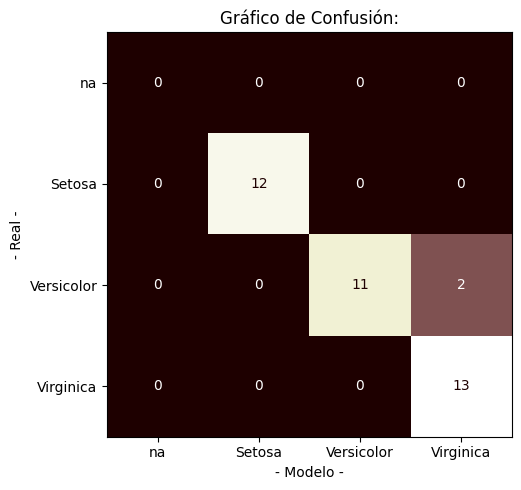

In [ ]:
#@title Evaluar con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = True #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
# muestra resultados
evaluarModelo(model, esProblemaClasificacion,
              datosX=x_test, datosY=y_test, clases_map=CLASES,
              tipo_output_softMax=tipo_output_softMax,
              umbralClas=umbral_clasificacion/100.0,
              mostrarDetalle=mostrar_detalle_prueba,
              inclDatosEntrada=incluirDatosEntrada_detalle_prueba)
